In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install bert

In [ ]:
# !pip install transformers

In [1]:
import pandas as pd

df = pd.read_parquet("hf://datasets/ade-benchmark-corpus/ade_corpus_v2/Ade_corpus_v2_classification/train-00000-of-00001.parquet")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [2]:
df = df.drop_duplicates()


In [3]:
df['label'].value_counts()

,count
label,
0,16625
1,4271


In [4]:
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
import seaborn as sns
import matplotlib as plt
from transformers import AutoModel, BertTokenizerFast
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [5]:
from transformers import AutoTokenizer, BertModel
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
import nltk
import re
import string
import pandas as pd
import numpy as np
from wordcloud import WordCloud
string.punctuation

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt_tab')
# Initialize stop words, English words corpus, and stemmer
stop_words = set(stopwords.words('english'))
english_words = set(words.words())
# stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [7]:
def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the text column
df['Cleantext'] = df['text'].apply(preprocess)

In [ ]:
df.head()

,text,label,Cleantext
0,Intravenous azithromycin-induced ototoxicity.,1,intravenous azithromycininduced ototoxicity
1,"Immobilization, while Paget's bone disease was...",1,immobilization pagets bone disease present per...
2,Unaccountable severe hypercalcemia in a patien...,1,unaccountable severe hypercalcemia patient tre...
3,METHODS: We report two cases of pseudoporphyri...,1,methods report two cases pseudoporphyria cause...
5,"Naproxen, the most common offender, has been a...",1,naproxen common offender associated dimorphic ...


In [ ]:
df['text'][0]

'Intravenous azithromycin-induced ototoxicity.'

In [ ]:
df['Cleantext'][0]

'intravenous azithromycininduced ototoxicity'

In [8]:
X=df.Cleantext
Y=df.label
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.20, random_state=42)

# Further split temp into test and validation
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
print(f'(X_train: {len(X_train)}\nx_val: {len(X_val)}\nx_test: {len(X_test)})')

(X_train: 16716
x_val: 2090
x_test: 2090)


In [9]:
import numpy as np



y_train_binarized = np.array([[1, 0] if label == 0 else [0, 1] for label in y_train])
y_val_binarized = np.array([[1, 0] if label == 0 else [0, 1] for label in y_val])
y_test_binarized = np.array([[1, 0] if label == 0 else [0, 1] for label in y_test])

# Check the shape of the one-hot encoded labels
print("Manually Binarized y_train shape:", y_train_binarized.shape)  # Should be (134, 2)
print("Manually Binarized y_val shape:", y_val_binarized.shape)      # Should be (33, 2)
print("Manually Binarized y_test shape:", y_test_binarized.shape)    # Should be (33, 2)


Manually Binarized y_train shape: (16716, 2)
Manually Binarized y_val shape: (2090, 2)
Manually Binarized y_test shape: (2090, 2)


In [10]:
X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()
y_val=y_val.tolist()
X_val=X_val.tolist()


In [11]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=649)
valid_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=649)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=649)


In [12]:
class DATALOADER(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])  # No need to wrap in a list
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = DATALOADER(train_encodings, y_train)
valid_dataset = DATALOADER(valid_encodings, y_val)
test_dataset = DATALOADER(test_encodings, y_test)

In [13]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import matthews_corrcoef
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  mcc = matthews_corrcoef(labels, preds)
  avg_precision = average_precision_score(labels, preds)
  return {
      'accuracy': acc,'matthews_corrcoef':mcc,'avg_precision':avg_precision,
  }

In [15]:
from transformers import TrainingArguments

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./bertade',
    num_train_epochs=10,  # Consider reducing this for early stopping
    fp16=True,
    per_device_train_batch_size=16,  # Lower batch size can help regularization
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    warmup_steps=500,  # Increase warmup steps to smooth the learning process
    weight_decay=0.05,  # Increase weight decay to add stronger regularization
    logging_dir='./logs',
    load_best_model_at_end=True,
    logging_steps=100,  # Log metrics more frequently for better monitoring
    save_steps=200,
    evaluation_strategy="steps",
    save_total_limit=3,  # Limit the number of checkpoints to save disk space
    learning_rate=2e-5,  # Lower learning rate can improve fine-tuning
    lr_scheduler_type="cosine",  # Use a cosine decay learning rate
    report_to=None  # Disables integrations like wandb
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [16]:
from transformers import  Trainer
from transformers import EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [17]:
import os
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_API_KEY"] = ""  # Clear any stored API key


In [18]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy,Matthews Corrcoef,Avg Precision
100,1.188700,0.468700,0.797129,0.000000,0.202871
200,0.805800,0.301389,0.869856,0.602631,0.530324
300,0.649200,0.315782,0.843541,0.625607,0.533376
400,0.563300,0.268196,0.883254,0.692082,0.604727
500,0.527500,0.244474,0.905263,0.708124,0.635643
600,0.447600,0.232841,0.904306,0.730727,0.650615
700,0.459400,0.271222,0.895694,0.707979,0.626318
800,0.442100,0.213809,0.906220,0.730982,0.652782
900,0.445600,0.188838,0.914354,0.726379,0.659564
1000,0.395400,0.192998,0.921053,0.760206,0.690839


Could not locate the best model at ./bertade/checkpoint-900/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


TrainOutput(global_step=1200, training_loss=0.5445378478368124, metrics={'train_runtime': 506.7484, 'train_samples_per_second': 329.868, 'train_steps_per_second': 10.301, 'total_flos': 2010702907281600.0, 'train_loss': 0.5445378478368124, 'epoch': 2.294736842105263})

# ROC Plot

## ROC Plot for train dataset

In [21]:
predictionstrain = trainer.predict(train_dataset)
logitstrain = predictionstrain.predictions
true_labelstrain = predictionstrain.label_ids


In [22]:
import torch
import numpy as np

logitstrain = torch.tensor(logitstrain)  # Replace with your actual logits

# If logits are a single column (one logit per sample), apply sigmoid and compute both probabilities
if logitstrain.ndimension() == 1:  # Single logit for class 1
    probabilitiestrain = torch.sigmoid(logitstrain).unsqueeze(1)  # P(class 1)
    probabilitiestrain = torch.cat([1 - probabilitiestrain, probabilitiestrain], dim=1).numpy()  # P(class 0), P(class 1)
else:
    # If logits already have shape (n_samples, 2) (two logits for each sample), apply softmax
    probabilitiestrain = torch.nn.functional.softmax(logitstrain, dim=1).numpy()  # Shape: (n_samples, 2)


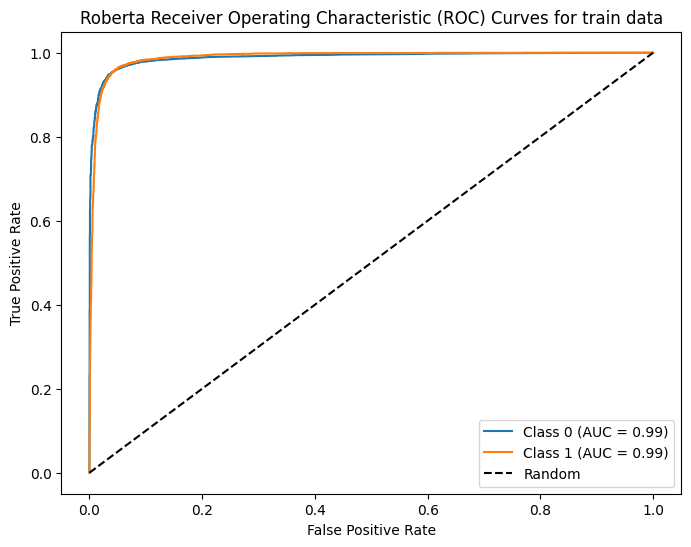

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Compute ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# For each class (0 and 1)
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_train_binarized[:, i], probabilitiestrain[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(2):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roberta Receiver Operating Characteristic (ROC) Curves for train data')
plt.legend(loc='lower right')
plt.show()




---



---

## ROC plot for test dataset

In [24]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
true_labels = predictions.label_ids


In [25]:
import torch
import numpy as np

logits = torch.tensor(logits)  # Replace with your actual logits

# If logits are a single column (one logit per sample), apply sigmoid and compute both probabilities
if logits.ndimension() == 1:  # Single logit for class 1
    probabilities = torch.sigmoid(logits).unsqueeze(1)  # P(class 1)
    probabilities = torch.cat([1 - probabilities, probabilities], dim=1).numpy()  # P(class 0), P(class 1)
else:
    # If logits already have shape (n_samples, 2) (two logits for each sample), apply softmax
    probabilities = torch.nn.functional.softmax(logits, dim=1).numpy()  # Shape: (n_samples, 2)


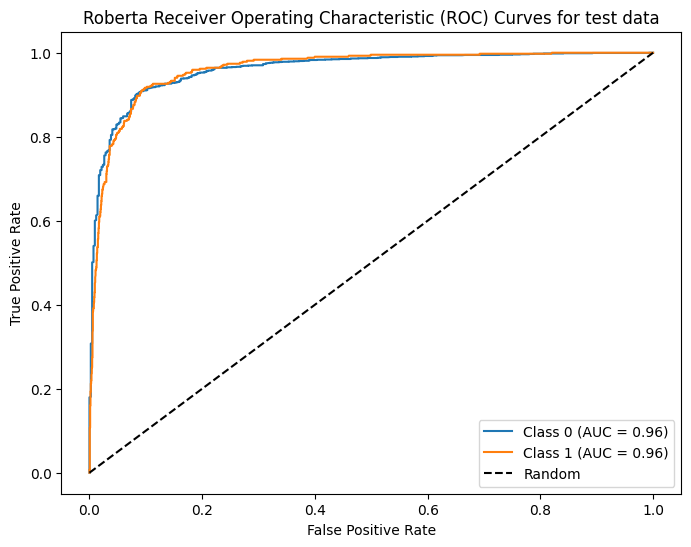

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Compute ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# For each class (0 and 1)
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
for i in range(2):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roberta Receiver Operating Characteristic (ROC) Curves for test data')
plt.legend(loc='lower right')
plt.show()


## Saved model

In [27]:
# saving the fine tuned model & tokenizer
model_path = "/content/drive/MyDrive/ADE/roberata-base-cased1"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/drive/MyDrive/ADE/roberata-base-cased1/tokenizer_config.json',
 '/content/drive/MyDrive/ADE/roberata-base-cased1/special_tokens_map.json',
 '/content/drive/MyDrive/ADE/roberata-base-cased1/vocab.json',
 '/content/drive/MyDrive/ADE/roberata-base-cased1/merges.txt',
 '/content/drive/MyDrive/ADE/roberata-base-cased1/added_tokens.json',
 '/content/drive/MyDrive/ADE/roberata-base-cased1/tokenizer.json')

## Evaluated model

In [28]:
trainer.evaluate()

{'eval_loss': 0.20215599238872528,
 'eval_accuracy': 0.9167464114832536,
 'eval_matthews_corrcoef': 0.7648106773265455,
 'eval_avg_precision': 0.6879988303221325,
 'eval_runtime': 4.3665,
 'eval_samples_per_second': 478.641,
 'eval_steps_per_second': 30.001,
 'epoch': 2.294736842105263}

In [29]:
eval_results =trainer.evaluate(test_dataset)

# Predict on the evaluation dataset to get logits
predictions = trainer.predict(test_dataset)

In [30]:
eval_results

{'eval_loss': 0.22992932796478271,
 'eval_accuracy': 0.9129186602870814,
 'eval_matthews_corrcoef': 0.7479820068418976,
 'eval_avg_precision': 0.66991181844173,
 'eval_runtime': 5.8227,
 'eval_samples_per_second': 358.939,
 'eval_steps_per_second': 22.498,
 'epoch': 2.294736842105263}

In [31]:
import numpy as np

# Extract true labels
true_labels = predictions.label_ids

# Extract predicted labels (argmax over logits)
preds = np.argmax(predictions.predictions, axis=1)


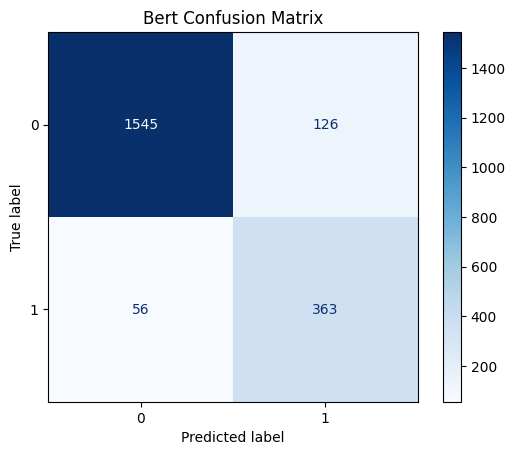

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = ['0', '1']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.title('Bert Confusion Matrix')
plt.show()


In [33]:
from sklearn.metrics import classification_report

# Assuming true_labels and preds are already defined
print(classification_report(true_labels, preds, target_names=labels))


              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1671
           1       0.74      0.87      0.80       419

    accuracy                           0.91      2090
   macro avg       0.85      0.90      0.87      2090
weighted avg       0.92      0.91      0.92      2090

